<a href="https://colab.research.google.com/github/LuizVicenteJr/insiders_clustering/blob/main/insiders_clustering_cycle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Planejamento da solução :

* Problema de negócio -> Selecionar os clientes mais valiosos para integrar um programa de fidelização

*Dataset -> Vendas de um e-commerce durante o período de um ano

#Perguntas da equipe de negócios :    
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
* Qual a expectativa de faturamente deste grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
*  Quais as condições para uma pessoa ser removida do Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de marketing pode realizar para aumentar o faturamento




# 0.0 IMPORTS

In [184]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap 
import regex as re

from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 HELPER FUNCTIONS

In [186]:
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

## 0.2 LOAD DATASET

In [187]:
df_raw = pd.read_csv('/content/Ecommerce.csv',encoding='unicode_escape')

#drop extra column
df_raw= df_raw.drop(columns=['Unnamed: 8'],axis=1)

# 1.0 DATA DESCRIPTION

In [188]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [189]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [190]:
cols_new =['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 DATA DIMENSIONS

In [191]:
print('Number of rows : {}'.format(df1.shape[0]))
print('Number of rows : {}'.format(df1.shape[1]))

Number of rows : 541909
Number of rows : 8


## 1.3 DATA TYPES

In [192]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 CHECK NA

In [193]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 REPLACE NA

In [194]:
df1 = df1.dropna(subset=['description','customer_id'])

print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))


Removed data: 0.25


## 1.6 CHANGE DTYPES

In [195]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [196]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [197]:
#invoice date
df1['invoice_date']= pd.to_datetime(df1['invoice_date'],format= '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7 DESCRIPTIVE STATISTICS

In [198]:
num_attributes= df1.select_dtypes(include=['int64','float64'])
cat_attributes= df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [199]:
#central tendency
ct1= pd.DataFrame(num_attributes.apply(np.mean)).T
ct2= pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion
d1= pd.DataFrame(num_attributes.apply(np.std)).T
d2= pd.DataFrame(num_attributes.apply(np.min)).T
d3= pd.DataFrame(num_attributes.apply(np.max)).T
d4= pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5= pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6= pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [200]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### <font color='red'> 1.7.1.1 Investigating</font>
* "quantity" negativa(pode ser devolução)
* "preço unitário igual a zero(pode ser algum tipo de promoção)

### 1.7.2 Categorical Attributes

In [201]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [202]:
#número de "invoice_no" com letras
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),'invoice_no'].drop_duplicates())

3654

In [203]:
#len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+',x))),'stock_code'])

df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2.0 DATA FILTER

In [204]:
df2 = df1.copy()

In [205]:
# Numerical Attributes 
df2= df2.loc[df2['unit_price']> 0.010,:]

#stock code
df2= df2[~df2['stock_code'].isin(['POST','D','M','DOT','CRUK','C2'])]

#description

#quantity
df2_returns= df2.loc[df2['quantity']< 0, :]
df2_purchase= df2.loc[df2['quantity']> 0, :]

## 3.0 FEATURE ENGINEERING

In [206]:
df3 = df2.copy()

In [207]:
df_ref= df3.drop(['invoice_no','stock_code','description','quantity',
                  'invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)

In [208]:
#gross revenue 
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

#monetary
df_monetary= df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref= pd.merge(df_ref,df_monetary,how='left',on='customer_id')
df_ref.isna().sum()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    27
dtype: int64

In [209]:
#recency
df_recency= df2_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days']= (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency= df_recency[['customer_id','recency_days']].copy()

df_ref= pd.merge(df_ref,df_recency,how='left',on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [210]:
#frequency
df_frequency= df2_purchase[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

df_ref= pd.merge(df_ref,df_frequency,how='left',on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [211]:
#average ticket
df_avg_ticket= df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_avg_ticket['avg_ticket']= np.round(df_avg_ticket['avg_ticket'],2)

df_ref= pd.merge(df_ref,df_avg_ticket,on='customer_id',how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [212]:
#Number of returns
df_returns= df2_returns[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'returns'})

df_ref= pd.merge(df_ref,df_returns,how='left',on='customer_id')
df_ref.loc[df_ref['returns'].isna(),'returns']= 0

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [213]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.15,1.0
1,13047,3232.59,56.0,9.0,18.90,7.0
2,12583,6705.38,2.0,15.0,28.90,2.0
3,13748,948.25,95.0,5.0,33.87,0.0
4,15100,876.00,333.0,3.0,292.00,3.0


# 4.0 EDA


In [214]:
df4= df_ref.dropna().copy()

# 5.0 DATA PREPARATION

In [215]:
from sklearn import preprocessing as pp

In [216]:
df5 = df4.copy()

In [217]:
ss= pp.MinMaxScaler()

df5['gross_revenue']= ss.fit_transform(df5[['gross_revenue']])
df5['recency_days']= ss.fit_transform(df5[['recency_days']])
df5['invoice_no']= ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket']= ss.fit_transform(df5[['avg_ticket']])
df5['returns']= ss.fit_transform(df5[['returns']])

# 6.0 FEATURE SELECTION

In [218]:
df6= df5.copy()

#7.0 Hyperparameter Fine-Tuning

In [219]:
X= df6.drop(columns=['customer_id'])

In [220]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,0.019301,0.997319,0.160976,0.000208,0.022222
1,0.011567,0.150134,0.039024,0.000218,0.155556
2,0.024009,0.005362,0.068293,0.000347,0.044444
3,0.003384,0.254692,0.019512,0.000412,0.000000
4,0.003125,0.892761,0.009756,0.003756,0.066667


In [221]:
clusters= [2,3,4,5,6,7]

In [222]:
#wss=[]
#for k in clusters:
  ##model definition
  #kmeans= c.KMeans(init='random',n_clusters=k,n_init=10,max_iter=300,random_state=42)

  ##model training
  #kmeans.fit(X)

  ##validation
  #wss.append(kmeans.inertia_)

##plot wss - elbow method
#plt.plot(clusters,wss,linestyle='--',marker= 'o',color= 'b')
#plt.xlabel('K');
#plt.ylabel('Within-Cluster Sum of Square'); 
#plt.title('WSS vs K');

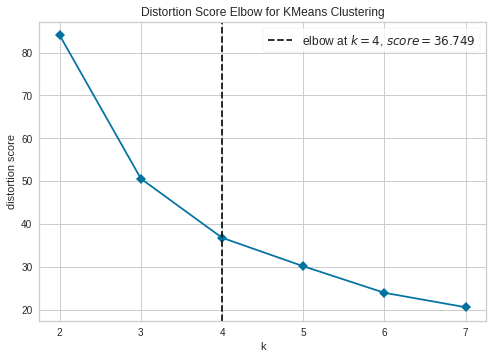

In [223]:
from yellowbrick.cluster import KElbowVisualizer

kmeans= KElbowVisualizer(c.KMeans(), k=clusters,timings=False)
kmeans.fit(X)
kmeans.show()

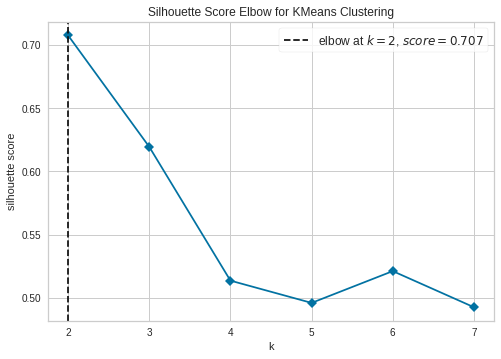

In [224]:
from yellowbrick.cluster import KElbowVisualizer
kmeans= KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show()

## 7.1 Silhouette Analysis

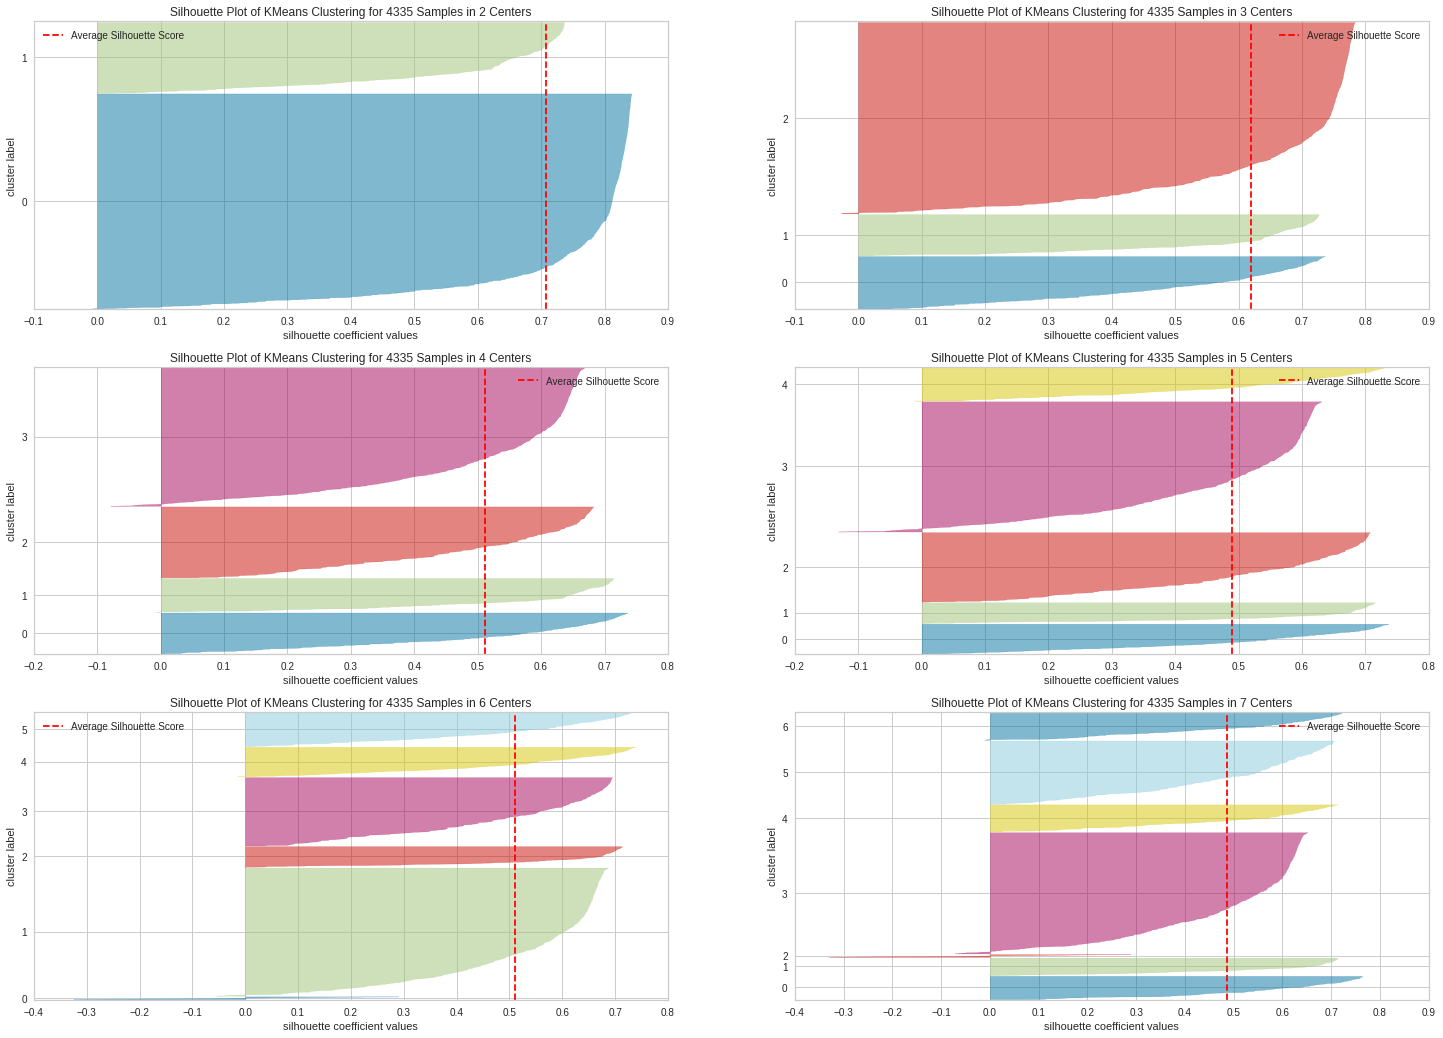

In [225]:
fig,ax= plt.subplots(3,2,figsize=(25,18))
for k in clusters: 
  km= c.KMeans(n_clusters= k, init='random',n_init=10, max_iter=100, random_state=42)
  q,mod= divmod(k,2)
  visualizer= SilhouetteVisualizer(km, colors='yellowbrick',ax= ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

# 8.0 MODEL TRAINING

## 8.1 K-MEANS

In [226]:
#model definition
k=6
kmeans= c.KMeans(init='random', n_clusters= k, n_init= 10, max_iter= 300)
#model training
kmeans.fit(X)

#clustering
labels= kmeans.labels_

## 8.2 Cluster Validation

In [227]:
from sklearn import metrics as m

In [228]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))
 
#SS
print('SS value: {}'.format(m.silhouette_score(X,labels,metric='euclidean')))

WSS value: 23.909282361031565
SS value: 0.5111320210898233


# 9.0 Cluster Analysis

In [229]:
df9 = df6.copy()
df9['cluster']= labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.022222,1
1,13047,0.011567,0.150134,0.039024,0.000218,0.155556,4
2,12583,0.024009,0.005362,0.068293,0.000347,0.044444,3
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000,4
4,15100,0.003125,0.892761,0.009756,0.003756,0.066667,1


## 9.1 Visualization Inspection

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


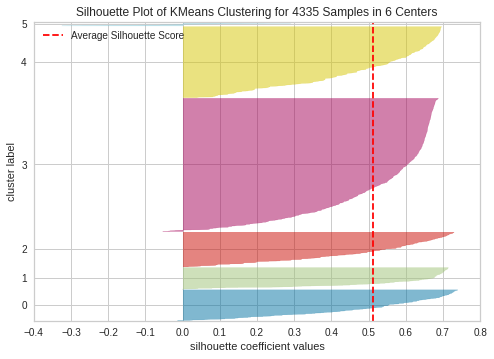

In [230]:
visualizer= SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2dplot

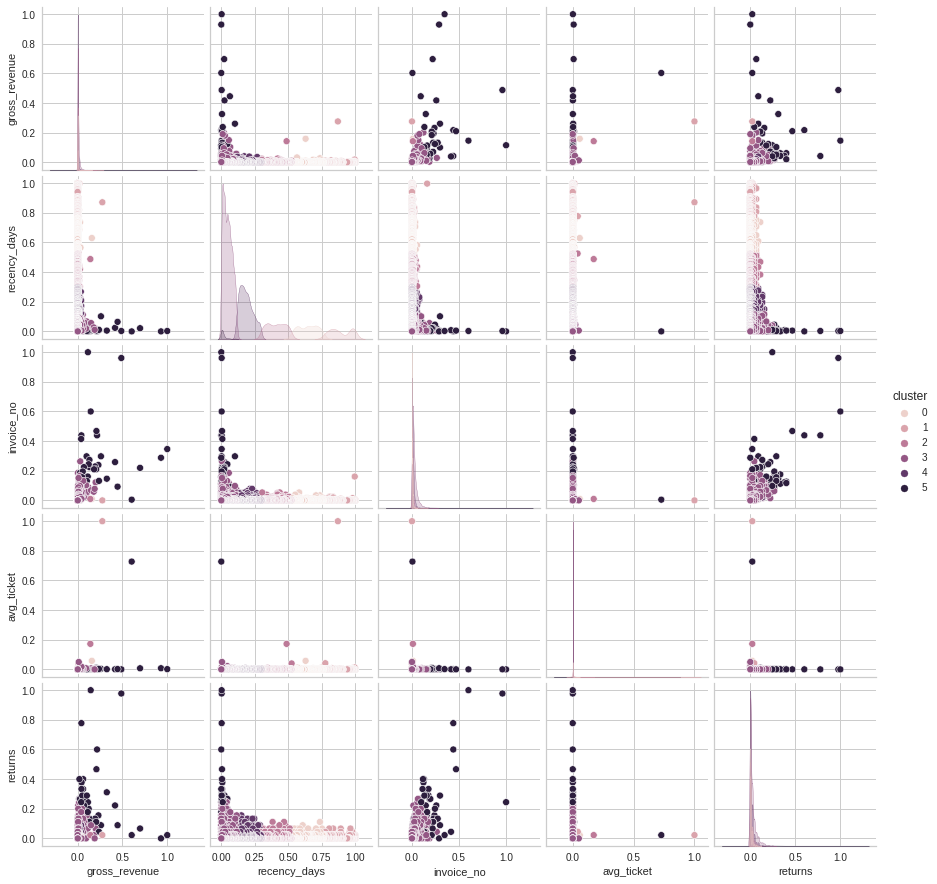

In [231]:
df_viz= df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz,hue='cluster')

## 9.3 UMAP

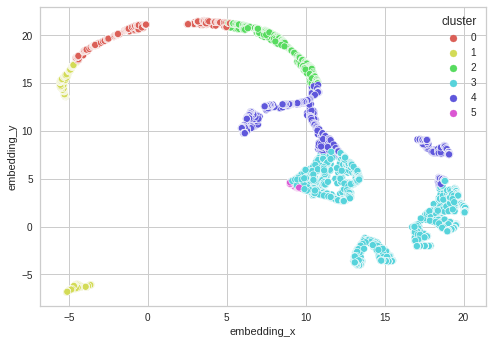

In [232]:
reducer= umap.UMAP(n_neighbors=80,random_state=42)
embedding= reducer.fit_transform(X)

#embedding
df_viz['embedding_x']= embedding[:,0]
df_viz['embedding_y']= embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls',n_colors=len(df_viz['cluster'].unique())),
                data= df_viz)